In [3]:
import pyNSRDB
import geopy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import requests
import pytz
from timezonefinder import TimezoneFinder
import pvlib
from pvlib import pvsystem, location, temperature, modelchain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hybrid_tea_model_photon import hybrid_tea_model_photon
import warnings
from scipy.interpolate import interp1d

warnings.filterwarnings('ignore')

################################################################# Retrieve TMY data ####################################################################

#%% System Constants and Parameters 
key = 'luke_test' # Define a key to associate with data
save_path = 'D:\Models\8760_ESS' # Define path to save data/figures to
interval = 30
# TMY Data Setup and PVlib Location

# gets coordinates given a location - default Page AZ
def get_location_coordinates(plant_location = "Page, Arizona"):
        geolocator = Nominatim(user_agent="photonvault")
        try:
            location = geolocator.geocode(plant_location)
            return location.latitude, location.longitude 
        except GeocoderTimedOut as e:
            print("error: geocode failed :( try another location "%(plant_location, e.message))

# retrieves tmy data from NSRDB for given coordinates and year
def get_tmy_data(lat, lon, year, interval=30, api_key = "Ay1bsdBsLr9ObP8gfuatHzoEU2pmOSXfwVWUcXCp"):
    attributes = 'ghi,dhi,dni,wind_speed,air_temperature,solar_zenith_angle'
    leap_year = 'false'
    interval = interval
    utc = 'true'
    your_name = 'NSTTF'
    reason_for_use = 'tea_analysis'
    your_affiliation = 'Sandia'
    your_email = 'johnsontaylor@ufl.edu'
    mailing_list = 'false'
    url = 'https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)
    data = pd.read_csv(url,nrows=3)
    data = pd.read_csv(url, header=2)
    return data

def get_timezone(latitude, longitude):
    tf = TimezoneFinder()
    timezone_str = tf.timezone_at(lat=latitude, lng=longitude)
    return timezone_str
    
# location_coods = get_location_coordinates("Page, Arizona") < blocked by firewall, proxy problem (?) resolve later 
# latitude, longitude  = location_coods[0], location_coods[1]
latitude, longitude = 36.9140854, -111.4551159
year = 2020
data = get_tmy_data(latitude, longitude, year)
DHI,DNI,GHI = data['DHI'],data['DNI'], data['GHI']                                                 # solar availability data
theta_z = data['Solar Zenith Angle']                                                               # solar zenith angle 
amb_temp = data['Temperature']
year,month,day,hour,minute = data['Year'],data['Month'], data['Day'], data['Hour'],data['Minute']  # time data 
tz = get_timezone(latitude,longitude)
no_ts = 2

<>:23: SyntaxWarning: invalid escape sequence '\M'
<>:23: SyntaxWarning: invalid escape sequence '\M'
C:\Users\tljohn\AppData\Local\Temp\ipykernel_31992\123078733.py:23: SyntaxWarning: invalid escape sequence '\M'
  save_path = 'D:\Models\8760_ESS' # Define path to save data/figures to


In [296]:
############################################################### Define study parameters ###############################################################

# Analysis Period 
period = 24*365*no_ts # Number of time steps for simulation

# Grid Load Profile - Simulated
hrs = np.arange(0, period, 1) # Setup interger hours of analysis
load = [350]*8760*no_ts # kWh
 
# CSP System Definition
n_collectors = 70  # Number of solar collectors
area_per_collector = 15  # Area per collector [m^2]
collecting_area = n_collectors * area_per_collector  # Total collecting area [m2]
eff_csp = 0.50  # CSP system efficiency

# TES System Definition
eff_particleheater = 0.99 # Particle Heater efficiency
tes_discharge_efficiency = 0.40  # TES discharge efficiency
tes_loss_rate = 0.020833333  # TES energy loss rate per hour
tes_capacity = 6000 # TES capacity [kWh_th]
tes_charge_efficiency = 0.95  # TES charge efficiency
tes_stored = 0 # Starting TES charge [kWh]
min_tes_output = 10  # Minimum TES output in kW_e 
maximum_hourly_tes_output = 200  # Maximum TES output in kW_e 
tes_min_threshold = 20  # Minimum energy level in kWh to maintain in TES

# PV System Setup
PV_AC_Rating = 300e3 # [W]
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter_parameters = {
    'Paco': PV_AC_Rating,  # AC power output [W]
    'Pdco': PV_AC_Rating * 2,  # DC power input [W]
    'Vdco': 6e3,  # DC voltage [V]
    'Pnt': 0.5,  # Night time power [W]
    'Pso': 0,  # Self-consumption power [W]
    'C0': -0.00025,
    'C1': 0.0001,
    'C2': 0.02,
    'C3': -0.04
}

#%% TEA Constants & Parameters 
C_PV = 890 # Cost of PV [$/kW]
C_CSP = 0 # Cost of CSP [$/collector]
C_TES = 0 # Cost per capacity of TES [$/kWh_th]
C_PB = 0 # Cost of power block [$/kW]

# O&M Defined Input
C_OM_TES = 15.0 # [$/kW-year] TES O&M cost
C_OM_CSP = 66 - C_OM_TES # [$/kW-year] CSP O&M cost
C_OM_PV = 22 # [$/kW-year] PV O&M cost

# TEA PARAMETERS
L = 30 # [yrs] Operational Life
n = 30 # [yrs] Analysis period
tax = 0.257 # [frac] State and federal tax rate
inflation = 0.028 # [frac] Inflation rate
ITC = 0.0 # [frac] Internal tax credit 
insurance = 0.004   #[frac] Insurance rate
property_tax = 0.0084 # [frac] Property Tax Rate
I = 0.08 # [frac] Nominal Interest rate 
COE = 0.13 # [frac] Cost of equity 
DF=0.5 #  [frac] Debt fraction
MACRS_yrs = 7 # [yrs] MACRS Depreciation Period 
PVD = 0.73281282777303 # [frac] Present Value of Depreciation based on MACRS_yrs
esc = 0.02 # [frac] Escalation rate

In [297]:
##################################################################### Performance Model ################################################################

# PV simulation 
tmy_data = pd.DataFrame({
    'dhi': DHI,
    'dni': DNI,
    'ghi': GHI,
    'Solar Zenith Angle': theta_z,
    'Year': year,
    'Month': month,
    'Day': day,
    'Hour': hour,
    'Minute': minute
})

tmy_data['DateTime'] = pd.to_datetime(tmy_data[['Year', 'Month', 'Day', 'Hour', 'Minute']])
tmy_data.set_index('DateTime', inplace=True)
tmy_data.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)


site = pvlib.location.Location(latitude, longitude, tz=tz)
if not tmy_data.index.tz:
    tmy_data.index = tmy_data.index.tz_localize('UTC').tz_convert(tz)
dni_data = tmy_data['dni'][:period]  # Direct Normal Irradiance data [W/m^2]
system = pvlib.pvsystem.PVSystem(surface_tilt=20, surface_azimuth=180,
                                 module_parameters=module,
                                 modules_per_string=1,
                                 inverter_parameters=inverter_parameters,
                                 temperature_model_parameters=pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass'])
mc = pvlib.modelchain.ModelChain(system, site, aoi_model='physical', spectral_model='no_loss', ac_model='sandia')
mc.run_model(tmy_data)
hourly_pv_output = interp_func(time_new)
hourly_pv_output=hourly_pv_output[:period]

# CSP Simulation
#csp_thermal_power = dni_data/1000 * collecting_area * eff_csp  # CSP thermal power [kW]
def csp_simulation(dni_data,ambient_temp,elevation_angle,azimuth,panel_inclination): 
    pipe_transmission_losses = 22*(250 - ambient_temp)/225
    incident_power =
    radiated_power = 
    net_power_after_radlosses = incident_power - radiated_power 
    net_power_received = 0 if net_power_after_radlosses - pipe_transmission_losses < 0 else net_power_after_radlosses - pipe_transmission_losses
    total_collection_area = n_collectors*area_per_collector
    flux = net_power_received/total_collection_area
    power = flux*total_collection_area
    


In [298]:
############################################################# Energy Balance Simulation ##############################################################

# modify to use excess PV to produce ice, first priority

# Energy Storage and Management Initialization
grid_power_required = np.zeros(period)
yearly_tes_stored = np.zeros(period)
total_energy_supplied = 0
total_grid_demand = np.sum(load)
excess_pv = np.zeros(period)
pv_to_grid = np.zeros(period)  
tes_to_grid = np.zeros(period)  
CSP_gen = np.zeros(period)

def energybalance(charge_tes_with_pv_excess):
    tes_stored = 0
    total_energy_supplied = 0
    yearly_tes_stored = np.zeros(period)
    CSP_gen = np.zeros(period)
    tes_to_grid = np.zeros(period)
    pv_to_grid = np.zeros(period)
    excess_pv = np.zeros(period)
    excess_pv_to_tes_nc = np.zeros(period)
    curtailed_energy = np.zeros(period)
    grid_power_required = np.zeros(period)
    
    dni_threshold = 0.5 * np.max(dni_data)  # 50% of the maximum DNI
    
    dni_below_threshold_count = 0  # Counter to track consecutive time steps below threshold
    
    for i in range(period):
        pv_generation = hourly_pv_output[i]
        charge_from_csp = csp_thermal_power[i]
        # Track CSP generation
        CSP_gen[i] = charge_from_csp
        
        # Determine if TES should discharge
        if dni_data[i] < dni_threshold:
            dni_below_threshold_count += 1
        else:
            dni_below_threshold_count = 0  # Reset count if DNI is above threshold

        # Discharge TES if DNI has been below threshold for at least two time steps
        if dni_below_threshold_count >= 2:
    
            # Charging TES from CSP
            possible_charge = min(charge_from_csp, tes_capacity - tes_stored)
            tes_stored += possible_charge * tes_charge_efficiency
            curtailed_energy[i] += (charge_from_csp - possible_charge) + possible_charge*(1-tes_charge_efficiency)
            
            # Apply TES energy loss
            tes_stored *= (1 - tes_loss_rate)
            curtailed_energy[i] += tes_stored * tes_loss_rate
            
            # Store the current TES level
            yearly_tes_stored[i] = tes_stored
            # Determine TES output based on stored energy and minimum discharge requirements
            if tes_stored > tes_min_threshold + min_tes_output / tes_discharge_efficiency:
                # Compute maximum TES output
                max_discharge = (tes_stored - tes_min_threshold) * tes_discharge_efficiency
                max_tes_output = min(max_discharge, maximum_hourly_tes_output)
                
                # Determine minimum TES output
                if pv_generation + min_tes_output < load[i]:
                    tes_output = min(max(min_tes_output, load[i] - pv_generation), max_tes_output)
                else:
                    tes_output = min_tes_output
            else:
                tes_output = 0  # No output if TES storage is below minimum holding threshold
            
        
        # If below discharging threshold, no output from TES
        else:
            tes_output = 0
            
        # Adjust TES stored energy
        tes_stored -= tes_output / tes_discharge_efficiency
        tes_to_grid[i] = tes_output
            
        # Calculate the actual PV contribution to the grid
        actual_pv_to_grid = min(pv_generation, load[i] - tes_output)
        pv_to_grid[i] = actual_pv_to_grid
        excess_pv[i] = max(0, pv_generation - actual_pv_to_grid)  # Calculate any excess PV   

        # Option to charge TES using excess PV electricity
        if charge_tes_with_pv_excess:
            excess_pv_thermal = excess_pv[i]*eff_particleheater 
            if excess_pv_thermal > tes_capacity - tes_stored:
                possible_tes_charge = tes_capacity - tes_stored
                excess_pv_to_tes_nc[i] = tes_capacity - tes_stored
                curtailed_energy[i] += excess_pv_thermal - (tes_capacity - tes_stored)
            else:
                possible_tes_charge = excess_pv_thermal
                excess_pv_to_tes_nc[i] = excess_pv_thermal
                curtailed_energy[i] += 0
            tes_stored += possible_tes_charge * tes_charge_efficiency 
            yearly_tes_stored[i] += possible_tes_charge * tes_charge_efficiency 
            
        
        # Check if the combined power from PV and TES meets the load
        if actual_pv_to_grid + tes_output >= load[i]:
            total_energy_supplied += load[i]
        else:
            total_energy_supplied += actual_pv_to_grid + tes_output
            grid_power_required[i] = load[i] - (actual_pv_to_grid + tes_output)
    
    load_met_percentage = (total_energy_supplied / total_grid_demand) * 100

    return load_met_percentage, yearly_tes_stored, CSP_gen, tes_to_grid, pv_to_grid, grid_power_required, excess_pv, excess_pv_to_tes_nc, curtailed_energy


combined_power_to_grid = pv_to_grid + tes_to_grid
total_power_to_grid = np.sum(combined_power_to_grid)
combined_power = hourly_pv_output + tes_to_grid

load_met_percentage, yearly_tes_stored, CSP_gen, tes_to_grid, pv_to_grid, grid_power_required, excess_pv, excess_pv_to_tes_nc, curtailed_energy = energybalance(charge_tes_with_pv_excess=False)
print("Load met percentage with charge_tes_with_pv_excess=False:", round(load_met_percentage,1))

print('***************************************************************************************************************************************')
load_met_percentage, yearly_tes_stored, CSP_gen, tes_to_grid, pv_to_grid, grid_power_required, excess_pv, excess_pv_to_tes_nc, curtailed_energy = energybalance(charge_tes_with_pv_excess=True)
print("Load met percentage with charge_tes_with_pv_excess=True:", round(load_met_percentage,1))

Load met percentage with charge_tes_with_pv_excess=False: 40.5
***************************************************************************************************************************************
Load met percentage with charge_tes_with_pv_excess=True: 40.5


Percentage of the load met by the PV and TES system: 40.54%


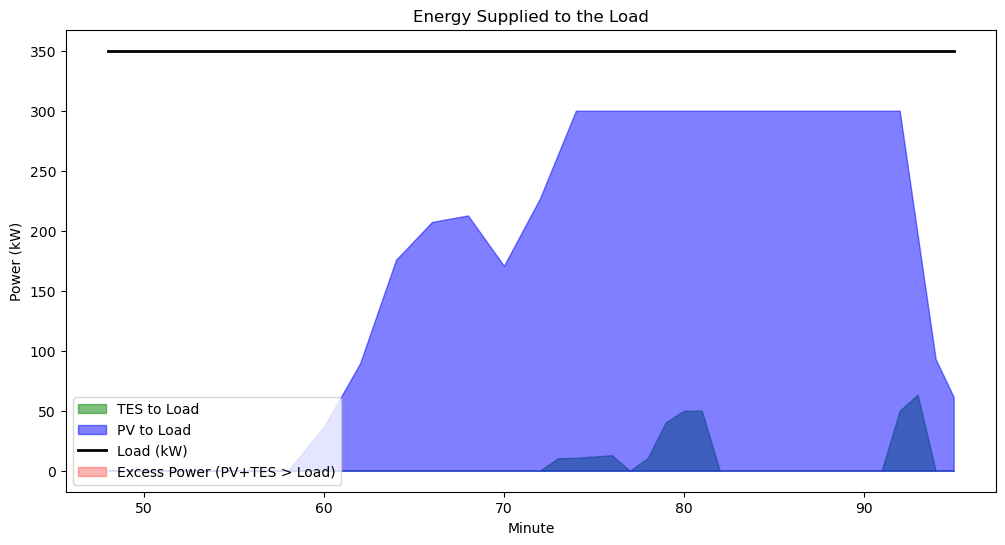

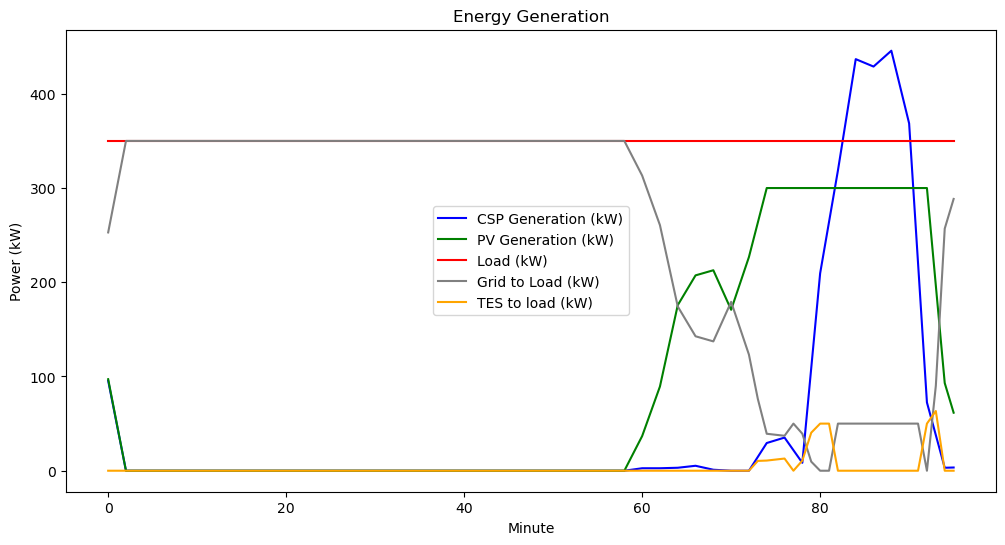

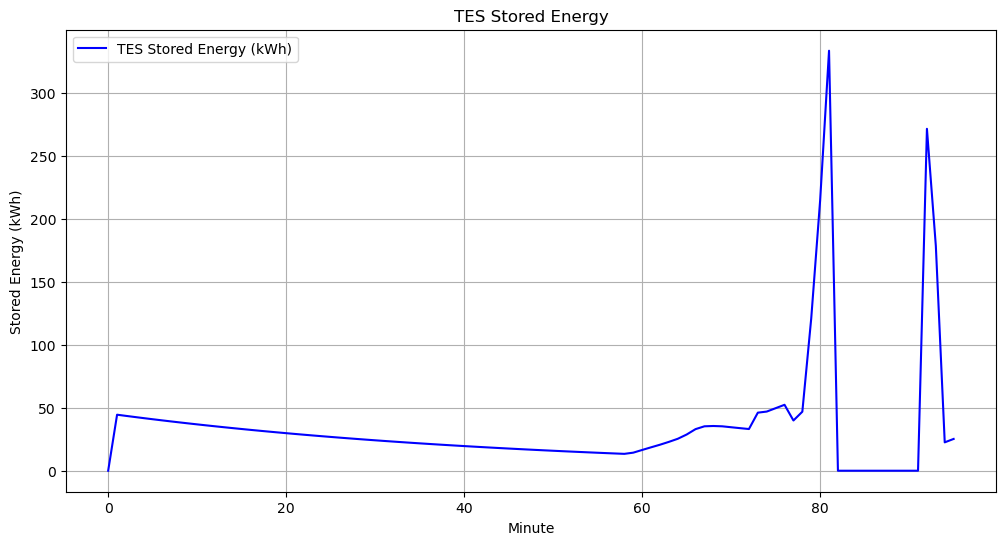

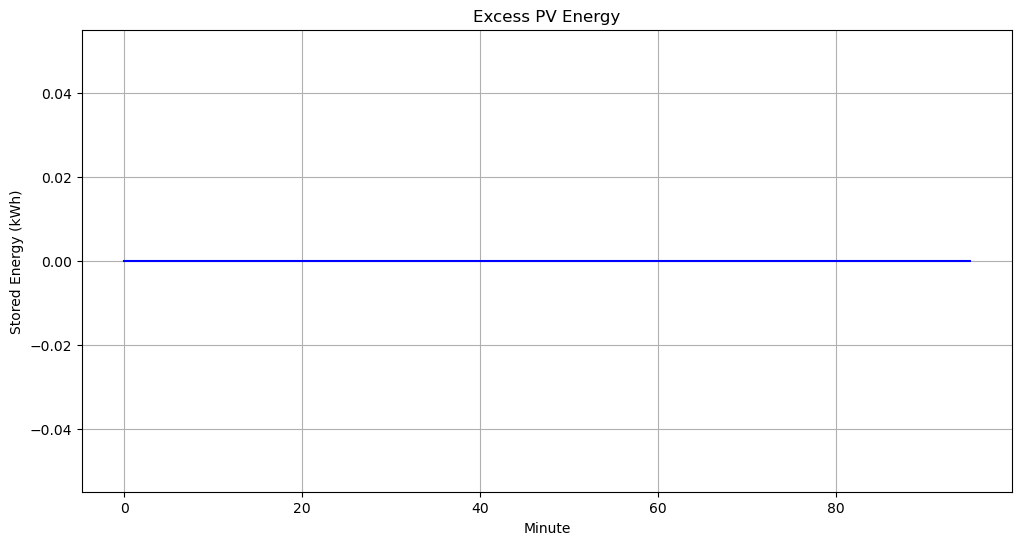

In [299]:
################################################################### Plotting ##########################################################################
display = 24*4
plt.figure(figsize=(12, 6))
plt.fill_between(hrs[48:display], 0, tes_to_grid[48:display], color='green', alpha=0.5, label='TES to Load')
plt.fill_between(hrs[48:display], pv_to_grid[48:display], combined_power_to_grid[48:display], color='blue', alpha=0.5, label='PV to Load')
plt.plot(hrs[48:display], load[48:display], label='Load (kW)', color='black', linewidth=2)
plt.fill_between(hrs[48:display], load[48:display], combined_power[48:display], where=(combined_power[48:display] > load[48:display]), color='red', alpha=0.3, label='Excess Power (PV+TES > Load)')

plt.xlabel('Minute')
plt.ylabel('Power (kW)')
plt.title('Energy Supplied to the Load')
plt.legend()
#plt.savefig(f'{save_path}\\to_load_{key}.png', bbox_inches='tight', pad_inches=0.1, dpi=500)

plt.figure(figsize=(12, 6))
plt.plot(hrs[0:display], CSP_gen[0:display], label='CSP Generation (kW)', color='blue')
plt.plot(hrs[0:display], hourly_pv_output[0:display], label='PV Generation (kW)', color='green')
plt.plot(hrs[0:display], load[0:display], label='Load (kW)', color='red')
plt.plot(hrs[0:display], grid_power_required[0:display], label='Grid to Load (kW)', color='gray')
plt.plot(hrs[0:display], tes_to_grid[0:display], label='TES to load (kW)', color='orange')

plt.xlabel('Minute')
plt.ylabel('Power (kW)')
plt.title('Energy Generation')
plt.legend()
#plt.savefig(f'{save_path}\\generation_{key}.png', bbox_inches='tight', pad_inches=0.1, dpi=500)

plt.figure(figsize=(12, 6))
plt.plot(hrs[0:display], yearly_tes_stored[0:display], label='TES Stored Energy (kWh)', color='blue')
plt.xlabel('Minute')
plt.ylabel('Stored Energy (kWh)')
plt.title('TES Stored Energy')
plt.legend()
plt.grid(True)
#plt.savefig(f'{save_path}\\stored_energy_{key}.png', bbox_inches='tight', pad_inches=0.1, dpi=500)

plt.figure(figsize=(12, 6))
plt.plot(hrs[0:display], excess_pv[0:display], label='Excess PV Energy (kWh)', color='blue')
plt.xlabel('Minute')
plt.ylabel('Stored Energy (kWh)')
plt.title('Excess PV Energy')
#"plt.legend()
plt.grid(True)
#plt.savefig(f'{save_path}\\stored_energy_{key}.png', bbox_inches='tight', pad_inches=0.1, dpi=500)

print(f"Percentage of the load met by the PV and TES system: {load_met_percentage:.2f}%")

In [300]:
#%% TEA Calculations 
combined_power_to_grid = pv_to_grid + tes_to_grid
total_power_to_grid = np.sum(combined_power_to_grid)
CAPEX = C_PV * PV_AC_Rating/1000 + C_TES * tes_capacity + C_PB * maximum_hourly_tes_output + C_CSP * n_collectors 

data = {'PV_AC_Rating': [PV_AC_Rating],
        'TES_capacity': [tes_capacity],
        'P_block': [maximum_hourly_tes_output],
        'CAPEX': [CAPEX],
        'PO': [total_power_to_grid],
        'load_met_percentage': [load_met_percentage]}
df = pd.DataFrame(data)

df[['LCOE','OM']] = df.apply(hybrid_tea_model_photon,axis=1,args=(C_OM_TES,C_OM_PV,C_OM_CSP,n,L,esc,DF,I,tax,COE,inflation,ITC,property_tax,insurance,MACRS_yrs,CAPEX),result_type='expand')
print('LCOE = '+str(np.round(float(df['LCOE']),3))+ ' $/kWh')

LCOE = 0.006 $/kWh
